# Project 1 - Recommender system for movies

## Data and methods

Let us start by reading the data:

In [1]:
from pyspark.sql.session import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
data = spark.read.csv("ratings.csv", header='true').drop('timestamp')
data.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      2|   3.5|
|     1|     29|   3.5|
|     1|     32|   3.5|
|     1|     47|   3.5|
|     1|     50|   3.5|
|     1|    112|   3.5|
|     1|    151|   4.0|
|     1|    223|   4.0|
|     1|    253|   4.0|
|     1|    260|   4.0|
|     1|    293|   4.0|
|     1|    296|   4.0|
|     1|    318|   4.0|
|     1|    337|   3.5|
|     1|    367|   3.5|
|     1|    541|   4.0|
|     1|    589|   3.5|
|     1|    593|   3.5|
|     1|    653|   3.0|
|     1|    919|   3.5|
+------+-------+------+
only showing top 20 rows



How many entries are there in the data?

In [4]:
data.count()

20000263

In [5]:
data.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          20000263|
|   mean|3.5255285642993797|
| stddev| 1.051988919294227|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



Converting the data into numeric values:

In [6]:
from pyspark.sql.types import DoubleType, IntegerType

data = data.withColumn("movieId", data["movieId"].cast(IntegerType()))
data = data.withColumn("userId", data["userId"].cast(IntegerType()))
data = data.withColumn("rating", data["rating"].cast(DoubleType()))
data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



## Sampling the data

In [7]:
import pandas as pd
data = pd.read_csv('ratings.csv').drop('timestamp', axis=1)

In [8]:
data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In order to train our models, we need to sample our data into a smaller dataset. We plan to create a user-based collaborative filtering, so we will need to compute the similarities between the users. We believe it is appropriate to select the most popular movies as it would be easier to evaluate the similarities in behavior between users.
<br> Let us start by selecting the movies that have more than 2,000 ratings:

In [9]:
counts = data['movieId'].value_counts()
data = data[data['movieId'].isin(counts.index[counts > 2000])]
data.groupby('movieId').nunique().count()

userId     2034
movieId    2034
rating     2034
dtype: int64

In [10]:
data.groupby('userId').nunique().count()

userId     138493
movieId    138493
rating     138493
dtype: int64

We end up with 1,005 distinct movies and 138,476 distinct users. 
<br>Let us randomly select 10,000 users to build our dataset.

In [11]:
import numpy as np
np.random.seed(1)
sample = data['userId'].unique()
sample_users = np.random.choice(sample, 10000)
dataset = data.loc[data['userId'].isin(sample_users)]
dataset

,userId,movieId,rating
922,10,1,4.0
923,10,11,4.0
924,10,25,4.0
925,10,260,4.0
926,10,356,3.0
...,...,...,...
19996960,138467,3261,5.0
19996961,138467,3262,4.0
19996962,138467,3264,4.0
19996966,138467,3358,4.0


In [12]:
dataset.groupby('movieId').nunique().count()

userId     2034
movieId    2034
rating     2034
dtype: int64

In [13]:
dataset.groupby('userId').nunique().count()

userId     9672
movieId    9672
rating     9672
dtype: int64

Interesting, we only have 9,672 users instead of 10,000... But well, it will be enough for our study!

Let us now split our datset in a train set and a test set. We will use both of them for the rest of our study in this homework:

In [14]:
dataset = spark.createDataFrame(dataset)
(training, test) = dataset.randomSplit([0.8,0.2], seed=0)
print(training.count(), test.count())

891927 223434


## Statistics

We can make some statistics about our new set of movies to better understand it. Here is the number of ratings each movie has:

In [15]:
stat = dataset.groupBy("movieId").count().sort('count', ascending=False)
stat.describe('count').show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|             2034|
|   mean| 548.358407079646|
| stddev|570.6818988465005|
|    min|              112|
|    max|             4592|
+-------+-----------------+



Even though we kept a small part of the users, we still have at least 326 ratings per movie which is enough for our study.

Here we can see the number of ratings with respect to the number of movies:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120a53bd0>]],
      dtype=object)

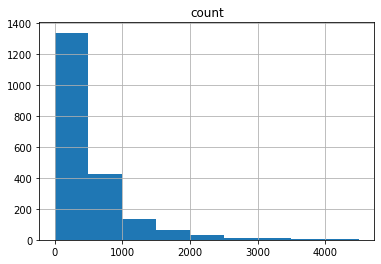

In [16]:
%matplotlib inline
import pandas as pd

panda_stat = stat.toPandas()
bin_ = [i*500 for i in range(10)]
panda_stat.hist(column='count', bins=bin_)

We can observe that the vast majority of the movies have less than 1,000 ratings and just a few of them have more ratings. This is the long tail effect: the popular movies (that represent a small proportion of the overall dataset) are far more rated than the other ones. 

# Metrics

In this section, we will define the metrics functions which we will use later to assess the performances of our models:
- MAE
- RMSE
- precision

MAE and RMSE:

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def RMSE(y, y_predicted):
    return np.sqrt(mean_squared_error(y, y_predicted))

Precision:

In [18]:
# Let us first create a function to transform our raw predictions into appropriate ones.
def round_rating(x): 
    dec = x - int(x)
    if (dec >= 0.25) and (dec < 0.75):
        return int(x) + 0.5
    else:
        return int(x) + (dec > 0.5)

# Precision function metric:
def precision(y, y_predicted):
    y_predicted = [round_rating(k) for k in y_predicted]       
    TP = 0
    for i in range(len(y)):
        if y[i] == y_predicted[i]:
            TP += 1
    return TP/len(y)

## Baseline Model

We first need a baseline model to later compare the performances of our personalized models. We will use this one: 
<br><br>
$$r_{ui}=\mu$$
<br>
with $\mu$: global average rating

In [19]:
training.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            891927|
|   mean|  3.59490687018108|
| stddev|1.0280125462518201|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



In [20]:
mu = 3.639545494108101

In [21]:
def baseline_rating(userId, movieId):
    return mu

In [22]:
test_baseline = test.toPandas()

In [23]:
import time

t0 = time.time()
y_predicted = []
for i in range(len(test_baseline.index)):
    movieId = test_baseline.iloc[i, 1]
    userId = test_baseline.iloc[i, 0]
    y_predicted.append(baseline_rating(userId, movieId))
t_baseline = time.time() - t0
print ("Time of the training:", t_baseline)

Time of the training: 2.9342148303985596


In [24]:
y = test_baseline['rating'].values

In [25]:
test_baseline['baseline_rating'] = y_predicted
test_baseline.head()

,userId,movieId,rating,baseline_rating
0,10,1,4.0,3.639545
1,10,260,4.0,3.639545
2,10,527,5.0,3.639545
3,10,1250,4.0,3.639545
4,10,1304,3.0,3.639545


In [26]:
mae_baseline = mean_absolute_error(y, y_predicted)
rmse_baseline = RMSE(y, y_predicted)
precision_baseline = precision(y, y_predicted)

print('MAE: ', mae_baseline, '\nRMSE: ', rmse_baseline, '\nprecision: ', precision_baseline, '\nRunning time: ', t_baseline)

MAE:  0.824087863416248 
RMSE:  1.0281187152910591 
precision:  0.1030505652675958 
Running time:  2.9342148303985596


We will compare the performances of our models with these values. 

## Memory Based: user-based model

### Computing Similarity matrix

Now we will focus on the training set to build an user similarity matrix, using the adjusted cosine similarity.

Let's first adjust each row to remove the user bias.
For that, we first compute the average rating per user, and we substract this average to each rating to obtain a non biased rating column:

In [27]:
Training = training.toPandas()
Testing = test.toPandas()
training_ratings_mean = Training.groupby('userId', as_index=False).mean().rename(columns = {'rating': 'rating_mean'})[['userId','rating_mean']]
training_ratings_mean.head()

,userId,rating_mean
0,10,3.933333
1,28,2.818182
2,49,3.857143
3,53,4.008333
4,81,4.833333


In [28]:
training_adjusted_ratings = pd.merge(Training, training_ratings_mean, on='userId', how='left', sort=False)
training_adjusted_ratings['rating_adjusted'] = training_adjusted_ratings['rating'] - training_adjusted_ratings['rating_mean']
training_adjusted_ratings.head()

,userId,movieId,rating,rating_mean,rating_adjusted
0,10,11,4.0,3.933333,0.066667
1,10,25,4.0,3.933333,0.066667
2,10,356,3.0,3.933333,-0.933333
3,10,858,5.0,3.933333,1.066667
4,10,912,4.0,3.933333,0.066667


In [29]:
training_adjusted_ratings = training_adjusted_ratings[['movieId', 'userId', 'rating_adjusted']]
training_adjusted_ratings.head()

,movieId,userId,rating_adjusted
0,11,10,0.066667
1,25,10,0.066667
2,356,10,-0.933333
3,858,10,1.066667
4,912,10,0.066667


Here, the last column of the dataframe contains the adjusted rating on each user. We will then use this column to compute the similarity between each users using cosine similarity:
- firstly, select two distinct users
- secondly, isolate items that have been rated by both users
- thirdly, apply similarity computation, which is defined as the following:

$$sim(u,v) = \frac{\sum_{i \in I}R_{u,i} R_{v,i}}{\sqrt{\sum_{i \in I}R_{u,i}^2 R_{v,i}^2}}$$
Where:
- $R_{u,i}$ is the mean centered rating of item i given by user U
- $I$ is the set of items that are rated by u and v

In order to compute the similarity matrix, we will use the cosine_similarity method from the Sklearn library.

Let's first create our rating matrix. We put the userId in rows because we want to create an **user based** model. We can see that it is a very sparse matrix:

In [30]:
# First the original ratings matrix, used to compute the predicted ratings
training_rating_matrix = Training.pivot_table(values='rating', 
                                              index='userId', 
                                              columns='movieId')
training_rating_matrix.head()

movieId,1,2,3,4,5,6,7,9,10,11,...,96079,96610,97304,97921,98809,99114,104841,106782,109374,112852
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Second the adusted rating matrix, used to compute the similarities between movies
training_adjusted_rating_matrix = training_adjusted_ratings.pivot_table(values='rating_adjusted', 
                                                                        index='userId', 
                                                                        columns='movieId')
training_adjusted_rating_matrix.head()

movieId,1,2,3,4,5,6,7,9,10,11,...,96079,96610,97304,97921,98809,99114,104841,106782,109374,112852
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,-0.008333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Creating a dummy matrix with 0 instead of Nan

dummy_training_adjusted_rating_matrix = training_adjusted_rating_matrix.copy().fillna(0)
dummy_training_adjusted_rating_matrix.head()

movieId,1,2,3,4,5,6,7,9,10,11,...,96079,96610,97304,97921,98809,99114,104841,106782,109374,112852
userId,,,,,,,,,,,,,,,,,,,,,
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,-0.008333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Importing the cosine similarity method from the Sklearn library
from sklearn.metrics.pairwise import cosine_similarity

# Computing the similarities
cosine_similarity = cosine_similarity(dummy_training_adjusted_rating_matrix, dummy_training_adjusted_rating_matrix)

In [34]:
# converting the cosine similarity into a similarity matrix
cosine_similarity = pd.DataFrame(cosine_similarity, 
                                 index=dummy_training_adjusted_rating_matrix.index, 
                                 columns=dummy_training_adjusted_rating_matrix.index)
cosine_similarity.head()

userId,10,28,49,53,81,124,127,163,167,180,...,138359,138365,138370,138380,138405,138408,138464,138465,138466,138467
userId,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.000000,0.000917,0.026053,-0.029083,0.008906,0.010196,0.053683,0.000000,0.000000,...,0.000000,-0.009054,-0.067611,0.002612,-0.063201,0.060723,0.034905,0.012706,0.000000,0.026500
28,0.000000,1.000000,0.150039,-0.059403,0.000000,0.056805,-0.062050,-0.002862,0.000000,0.132238,...,-0.045947,0.038491,-0.090442,0.000000,0.117946,0.000000,-0.001250,0.000000,0.000000,0.035324
49,0.000917,0.150039,1.000000,-0.004249,0.009110,0.042541,-0.075128,-0.009466,0.007655,0.086317,...,-0.015181,0.073422,0.034066,-0.005319,0.079190,-0.008037,0.010231,0.089315,0.046503,0.034803
53,0.026053,-0.059403,-0.004249,1.000000,-0.018794,0.029115,0.003231,-0.000222,-0.032193,-0.027180,...,-0.000270,-0.004438,0.066201,-0.021044,0.007466,-0.027017,0.005834,0.019843,0.041553,-0.007571
81,-0.029083,0.000000,0.009110,-0.018794,1.000000,-0.016746,0.012056,0.000000,0.014634,0.000000,...,-0.037031,0.013710,0.024520,-0.012975,0.000000,-0.018951,0.020575,0.000000,0.000000,0.000368


### Computing predicted ratings

Now we can complete the rating matrix by computing each missing rating using weighted mean ratings. 
More precisely, each missing entry is given by : 

$$ r_{u,i} = \frac{\sum_{i \in N}Similarity_{u,v} * r_{v,i}}{\sum_{j \in N}\mid\mid Similarity_{u,v} \mid\mid } $$

where $N$ is the set of users that have rated $i$.

In [35]:
import heapq
def user_based_collab(userId, movieId, k=10):
    
    # First check if the user is in the training set. Otherwise we do not have computed similarities for her.
    if userId in training_rating_matrix.index:
        
        # get the similarities between the movie and the other movies
        user_similarities = cosine_similarity[userId]
        #print('User Similarities: ', user_similarities)
        
        # Get all the other users' ratings for this movie
        other_users_ratings = training_rating_matrix[movieId]
        #print('other users ratings: ', other_users_ratings)
        
        # Remove the NaN from the users' ratings and from the similarity vector
        nan_index = other_users_ratings[other_users_ratings.isnull()].index
        other_users_ratings = other_users_ratings.dropna()
        user_similarities = user_similarities.drop(nan_index)
        #print('DROPING NAN')
        #print('User Similarities: ', user_similarities)
        #print('other users ratings: ', other_users_ratings)
        
        # take k nearest neighbors
        k_index = user_similarities[user_similarities.isin(heapq.nlargest(k, user_similarities))].index
        other_users_ratings = other_users_ratings[k_index]
        user_similarities = user_similarities[k_index]
        #print('TAKING K NEAREST')
        #print('User Similarities: ', user_similarities)
        #print('other users ratings: ', other_users_ratings)
           
        
        # Compute the predicted rating
        s = 0
        for sim in user_similarities:
            s += abs(sim)
        if s > 0:
            return np.dot(user_similarities, other_users_ratings) / s
        else:
            return mu
    
        
    # If the user or the movie were not in the training set, return the average rating
    else:
        return mu

In [36]:
t0 = time.time()
predictions_user_based =[]
for row in Testing.index:        
    userId = Testing.loc[row, 'userId']
    movieId = Testing.loc[row, 'movieId']
    rating = user_based_collab(userId, movieId)
    predictions_user_based.append(rating)
t_user_based = time.time() - t0
print ("Time of the training:", t_user_based)

Time of the training: 910.9235987663269


In [37]:
Testing['User_based_predictions'] = predictions_user_based
Testing

,userId,movieId,rating,User_based_predictions
0,10,1,4.0,3.450373
1,10,260,4.0,4.493974
2,10,527,5.0,4.228111
3,10,1250,4.0,3.834499
4,10,1304,3.0,3.887089
...,...,...,...,...
223429,138467,2571,5.0,4.352845
223430,138467,2717,4.0,2.988727
223431,138467,2997,5.0,4.214984
223432,138467,3101,3.0,3.732500


In [38]:
y_1 = Testing['rating']
y_predicted_1 = Testing['User_based_predictions']

mae_user_based = mean_absolute_error(y_1, y_predicted_1)
rmse_user_based = RMSE(y_1, y_predicted_1)
precision_user_based = precision(y_1, y_predicted_1)                                     

print('MAE: ', mae_user_based, '\nRMSE: ', rmse_user_based, '\nprecision: ', precision_user_based, '\nRunning time: ', t_user_based)

MAE:  0.7114360141571938 
RMSE:  0.9132074088126835 
precision:  0.22842987190848305 
Running time:  910.9235987663269


Fortunately, we can observe an improvement in our metrics by ...
This model is more effective than the baseline model because it is more personalized. Indeed, it takes into account the users behaviors and their similarities. However, due to an important sparsity, this is not the best that can be done: the performances would be poorer if we had taken less popular movies with fewer ratings in our sample dataset.

In [39]:
Testing.to_csv('predictions_user_based_2000movies')

## Model Based: Matrix Factorization

### 1. Simple ALS method
We will first create a simple ALS method to fit the training set, without fitting the hyper parameters.
We start with a rank of 20, 20 iterations, $\lambda=0.01$ and we set the constraint of non-negativity to True. 

Let's first import the required packages:

In [40]:
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [41]:
# Create ALS Model
SimpleAls = ALS(rank=20, maxIter=20, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)

In [42]:
import time

t0 = time.time()
SimpleModel = SimpleAls.fit(training)
t_simpleALS = time.time() - t0
print ("Time of the training:", t_simpleALS)

Time of the training: 15.947612762451172


We can therefore use the simple model to compute the predictions:

In [43]:
# Define evaluator as RMSE
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
evaluator_mae = RegressionEvaluator(metricName='mae', labelCol='rating', predictionCol='prediction')

In [44]:
# Generate predictions and evaluate RMSE
predictions_training_1 = SimpleModel.transform(training)
predictions_test_1 = SimpleModel.transform(test)

rmse_training_1 = evaluator_rmse.evaluate(predictions_training_1)
rmse_test_1 = evaluator_rmse.evaluate(predictions_test_1)

mae_training_1 = evaluator_mae.evaluate(predictions_training_1)
mae_test_1 = evaluator_mae.evaluate(predictions_test_1)

In [45]:
predictions_test_1.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
| 20924|    471|   4.0|  2.803015|
|109342|    471|   5.0| 3.6425428|
| 10303|    471|   2.0| 3.6026187|
| 84272|    471|   3.5| 3.1753533|
| 62003|    471|   4.0| 3.3642368|
| 78157|    471|   5.0| 4.4525547|
|  8325|    471|   5.0| 3.4691749|
|115672|    471|   4.0| 4.2891455|
| 51003|    471|   4.0|  4.231404|
| 69596|    471|   4.0| 3.6425512|
| 55995|    471|   5.0| 4.6006656|
| 72765|    471|   4.0|    4.2605|
|108399|    471|   4.0| 3.9364438|
|126273|    471|   4.0| 3.1878567|
| 27646|    471|   4.0| 3.1887436|
| 90358|    471|   4.0| 3.7539353|
|  6847|    471|   4.0| 3.7991736|
| 60525|    471|   3.0| 3.8445559|
| 37897|    471|   3.0| 3.5413694|
| 37404|    471|   3.0| 3.4131258|
+------+-------+------+----------+
only showing top 20 rows



In [46]:
df_predictions_training_1 = predictions_training_1.toPandas()
df_predictions_test_1 = predictions_test_1.toPandas()
precision_simpleALS_training = precision(df_predictions_training_1['rating'], df_predictions_training_1['prediction'])  
precision_simpleALS_test = precision(df_predictions_test_1['rating'], df_predictions_test_1['prediction'])  

print('For the training set:')
print('MAE: ', mae_training_1, '\nRMSE: ', rmse_training_1, '\nprecision: ', precision_simpleALS_training)
print()
print('For the test set:')
print('MAE: ', mae_test_1, '\nRMSE: ', rmse_test_1, '\nprecision: ', precision_simpleALS_test)
print()
print('Running time', t_simpleALS)

For the training set:
MAE:  0.4810207485487132 
RMSE:  0.6310630919718148 
precision:  0.3499793144506221

For the test set:
MAE:  0.6430344255569492 
RMSE:  0.8486849943669819 
precision:  0.2674481054808131

Running time 15.947612762451172


This model is quite simple, we did not try to fit the hyperparameters, namely the dimension of the latent vectors (rank of the matrix), the number of ALS iterations and the regularization parameter.
<br>Despite its simplicity, it is way better than the user-based model. The running is much lower which means that we can afford to often compute new predictions for a larger dataset.
<br><br>
We can now generate Top 10 user recommendations:

In [47]:
userRecs = SimpleModel.recommendForAllUsers(10).toPandas().set_index('userId')
userRecs.head()

,recommendations
userId,
7340,"[(6773, 4.900662899017334), (5690, 4.889193534..."
13840,"[(914, 5.533960819244385), (1035, 5.5053625106..."
41890,"[(112852, 4.691947937011719), (8638, 4.4866318..."
83250,"[(5690, 6.769101142883301), (27611, 6.41861581..."
18051,"[(2318, 8.468245506286621), (2387, 7.878695964..."


### 2. Better ALS method: fitting the hyperparameters

One way to improve our previous model is to fit the hyperparameters to the model. For this, we are using the *pyspark.ml.tuning* library and its ParamGridBuilder function.

Here we are offering differents possibilites for the hyperparameters and the model will try them all to find the best one.

In [48]:
# Create ALS Model
FitALS = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)

In [49]:
# Tune model using ParamGridBuilder
param_grid = ParamGridBuilder().addGrid(FitALS.rank, [15,17,20]).addGrid(FitALS.maxIter, [15,20,25]).addGrid(FitALS.regParam, [.01,.05,.1]).build()

Let us use a cross-validation set up to train and tune our model. We will split the training set into a train set and a tune set, with ratio 0.8, 0.2 respectively:

In [50]:
# Build cross validation using TrainValidationSplit
tvs = TrainValidationSplit(estimator=FitALS, estimatorParamMaps=param_grid, evaluator=evaluator_rmse, trainRatio=0.8)

In [51]:
# Fit ALS model to train data
import time

t0 = time.time()
FitModel = tvs.fit(training)
t_fitALS = time.time() - t0
print ("Time of the training:", t_fitALS)

Time of the training: 674.2750627994537


Let's save the model:

In [52]:
FitModel.save("FitModelALS_2000movies")

In [53]:
# Extract the best model from the tuning of Hyperparameters
best_model = FitModel.bestModel

In [54]:
# Generate predictions and evaluate RMSE
predictions_training_2 = best_model.transform(training)
predictions_test_2 = best_model.transform(test)

rmse_training_2 = evaluator_rmse.evaluate(predictions_training_2)
rmse_test_2 = evaluator_rmse.evaluate(predictions_test_2)

mae_training_2 = evaluator_mae.evaluate(predictions_training_2)
mae_test_2 = evaluator_mae.evaluate(predictions_test_2)

We can print the metrics for this new model:

In [55]:
df_predictions_training_2 = predictions_training_2.toPandas()
df_predictions_test_2 = predictions_test_2.toPandas()
precision_simpleALS_training = precision(df_predictions_training_2['rating'], df_predictions_training_2['prediction'])  
precision_simpleALS_test = precision(df_predictions_test_2['rating'], df_predictions_test_2['prediction'])  

print('Best hyperparameters found: ')
print('Rank:', best_model.rank)
print('MaxIter:', best_model._java_obj.parent().getMaxIter())
print('RegParam:', best_model._java_obj.parent().getRegParam())
print()
print('Metrics: ')
print('For the training set:')
print('MAE: ', mae_training_2, '\nRMSE: ', rmse_training_2, '\nprecision: ', precision_simpleALS_training)
print()
print('For the test set:')
print('MAE: ', mae_test_2, '\nRMSE: ', rmse_test_2, '\nprecision: ', precision_simpleALS_test)
print()
print('Running time', t_fitALS)

Best hyperparameters found: 
Rank: 20
MaxIter: 25
RegParam: 0.1

Metrics: 
For the training set:
MAE:  0.580730263812518 
RMSE:  0.7432814577503993 
precision:  0.278134869781944

For the test set:
MAE:  0.6249016755286761 
RMSE:  0.8030013699715939 
precision:  0.2600544232301261

Running time 674.2750627994537


We see that the **error** is much lower than the previous one. Fitting the hyperparameters is effective.

Let's see how our model predict the actual ratings of the test set:

In [56]:
predictions_test_2.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
| 20924|    471|   4.0| 3.3842738|
|109342|    471|   5.0| 3.5155904|
| 10303|    471|   2.0| 3.5598423|
| 84272|    471|   3.5|  3.615347|
| 62003|    471|   4.0| 3.0425408|
| 78157|    471|   5.0| 4.2493663|
|  8325|    471|   5.0| 3.6070476|
|115672|    471|   4.0|   4.11361|
| 51003|    471|   4.0| 3.4260638|
| 69596|    471|   4.0| 3.6280766|
| 55995|    471|   5.0| 3.7864935|
| 72765|    471|   4.0| 4.0653067|
|108399|    471|   4.0| 3.4060042|
|126273|    471|   4.0| 3.4876924|
| 27646|    471|   4.0| 3.3718226|
| 90358|    471|   4.0| 3.3369744|
|  6847|    471|   4.0| 3.8846874|
| 60525|    471|   3.0| 3.5209608|
| 37897|    471|   3.0| 3.7177033|
| 37404|    471|   3.0| 3.0095532|
+------+-------+------+----------+
only showing top 20 rows



We can now generate the top 10 recommendations for all users:

In [57]:
user_recs_fit = best_model.recommendForAllUsers(10).toPandas().set_index('userId')
user_recs_fit.head()

,recommendations
userId,
7340,"[(5618, 3.7806320190429688), (7099, 3.77805590..."
13840,"[(527, 4.752536773681641), (1207, 4.5672874450..."
41890,"[(2959, 4.125954627990723), (318, 4.1196269989..."
83250,"[(5618, 5.04010534286499), (2360, 5.0140237808..."
18051,"[(318, 4.646414279937744), (4880, 4.5492238998..."
